In [57]:
import pandas as pd
import numpy as np
from indicnlp.tokenize import indic_tokenize  
from gensim.models import Word2Vec
import re
import html
import tqdm 
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import pickle
from spacy.lang.hi import STOP_WORDS as STOP_WORDS_HI
import hindi_stemmer  ## https://research.variancia.com/hindi_stemmer/
import matplotlib.pyplot as plt

In [23]:
def loadFromPickle(pickleFile):
	file = open(pickleFile,'rb')
	pickleData = pickle.load(file)
	file.close()
	return pickleData

def saveInPickle(data, pickleFile):
	file = open(pickleFile,"wb")
	pickle.dump(data,file)
	file.close()

In [50]:
dataset = pd.read_csv("../dataset/hindi_dataset/hindi_dataset/hindi_dataset.tsv", delimiter="\t")
word2vec_model = Word2Vec.load("../embeddings/hindi-word2vec/hi.bin")
re1 = re.compile(r' +')
test_set = pd.read_csv("../dataset/hindi_dataset/hindi_dataset/hasoc2019_hi_test_gold_2919.tsv", delimiter="\t")

In [52]:
def pre_process(dataset):
    sentences = dataset["text"].tolist()
    data_labels = dataset["task_1"].tolist()
    vectors = []
    labels = []
    sentence_tokens = []
    
    for i, sentence in tqdm.tqdm(enumerate(sentences)):
        tokens = indic_tokenize.trivial_tokenize(sentence)
#         tokens = [token for token in tokens if token not in STOP_WORDS_HI]
#         tokens = [hindi_stemmer.hi_stem(token) for token in tokens]
        sentence_tokens.append(tokens)
        label = get_binary_labels(data_labels[i])
        labels.append(label)
    
    return sentence_tokens, labels

def get_binary_labels(label):
    if(label=="HOF"):
        return 1
    else:
        return 0

In [53]:
train_sentences, train_labels = pre_process(dataset)
test_sentences, test_labels = pre_process(test_set)
train_vectors = vec.vectorize_train(train_sentences)
test_vectors = vec.vectorize_test(test_sentences)
test_vectors.shape

4665it [00:00, 23020.22it/s]
1318it [00:00, 19713.83it/s]


(1318, 20926)

In [41]:
saveInPickle(train_vectors, "tfidf_train")
saveInPickle(x_test, "tfidf_test")

In [42]:
train_vectors = loadFromPickle("tfidf_train")
test_vectors = loadFromPickle("tfidf_test")

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC

model_names = ['QDA', 'LDA', 'MLP', 'LR', 'DT', 'RF', 'NB', 'KNN', 'AdaBoost', 'SVM']

models = [
    LinearDiscriminantAnalysis(),
    MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1), 
    LogisticRegression(random_state=0, penalty='none'),
    tree.DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators=100),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=5),
    AdaBoostClassifier(n_estimators=100, random_state=0),
    svm.SVC(kernel='linear',probability=True)
]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc', 'p', 'r', 'acc', 'f1'])

for i, model in enumerate(models):
    print(model.__class__.__name__)
    model.fit(train_vectors, train_labels)
    y_predicted = model.predict(train_vectors)
    print(accuracy_score(y_predicted, train_labels))
    y_predicted = model.predict(test_vectors)
    acc = accuracy_score(y_predicted, test_labels)
    print("test acc :", acc)
    y_prob = model.predict_proba(test_vectors)[::,1]
    fpr, tpr, _ = roc_curve(test_labels, y_prob)
    auc = roc_auc_score(test_labels, y_prob)
    precision = precision_score(y_predicted, test_labels)
    recall = recall_score(y_predicted, test_labels)
    fscore = f1_score(y_predicted, test_labels)
    print("auc :" ,auc )
    print("precision :", precision)
    print("recall :", recall)
    print("f_score :", fscore )
    result_table = result_table.append({'classifiers':model.__class__.__name__,
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'auc':auc,
                                    'p': precision,
                                    'r': recall,
                                    'acc' :acc,
                                    'f1': fscore}, ignore_index=True)
    print("\n\n")
    
result_table.set_index('classifiers', inplace=True)

LinearDiscriminantAnalysis
0.9993569131832798
test acc : 0.5887708649468892
auc : 0.5874445075516095
precision : 0.571900826446281
recall : 0.5500794912559619
f_score : 0.560777957860616



MLPClassifier
0.9952840300107181
test acc : 0.7754172989377845
auc : 0.8252002364586835
precision : 0.824793388429752
recall : 0.7242380261248186
f_score : 0.7712519319938176



LogisticRegression
0.9993569131832798
test acc : 0.7625189681335357
auc : 0.7984722914469184
precision : 0.7933884297520661
recall : 0.718562874251497
f_score : 0.7541241162608013



DecisionTreeClassifier
0.6512325830653805
test acc : 0.5918057663125948
auc : 0.7100923811621249
precision : 0.8264462809917356
recall : 0.5359056806002144
f_score : 0.6501950585175553



RandomForestClassifier
0.9993569131832798
test acc : 0.7867981790591806
auc : 0.8670140136543298
precision : 0.8066115702479338
recall : 0.7484662576687117
f_score : 0.7764518695306284



GaussianNB
0.969989281886388
test acc : 0.6858877086494689
auc : 0.691400

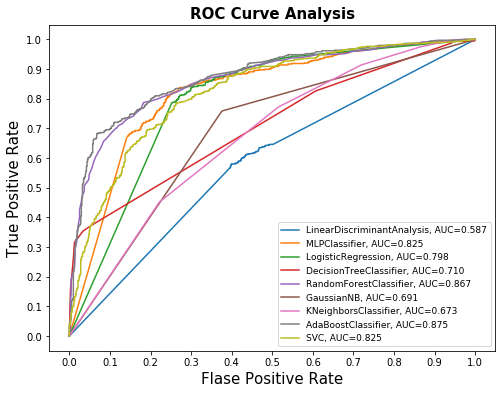

In [66]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':9}, loc='lower right')

plt.show()